# Coding Discussion #6
Build a model that predicts the log selling price of a house in DC based on the number of bathrooms, the number of bedrooms, and the size of the land.

### Preparation

In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import GradientBoostingRegressor as GBR

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [2]:
# Import train and test data sets
train = pd.read_csv('../train_data.csv')
test = pd.read_csv('../test_data.csv')

# Preview train data set
train.head(5)

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,NUM_UNITS,ROOMS,BEDRM,...,ROOF,ROOF_D,INTWALL,INTWALL_D,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,LN_PRICE
0,78021,4061N 0085,3.0,1.0,1.0,Forced Air,Y,1.0,9.0,4.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,11,2234,2018-07-22T18:01:43.000Z,13.591116
1,28783,1587 0075,2.0,1.0,7.0,Warm Cool,Y,1.0,7.0,3.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,3850,2018-07-22T18:01:43.000Z,12.730801
2,35035,2024 0817,2.0,2.0,13.0,Hot Water Rad,Y,1.0,9.0,4.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,7866,2018-07-22T18:01:43.000Z,13.651814
3,67983,3736 0059,1.0,1.0,7.0,Warm Cool,Y,1.0,6.0,3.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,13,2739,2018-07-22T18:01:43.000Z,12.860999
4,8791,0817 0826,2.0,0.0,13.0,Hot Water Rad,N,1.0,11.0,4.0,...,6.0,Metal- Sms,6.0,Hardwood,1.0,0.0,11,2097,2018-07-22T18:01:43.000Z,14.100690


In [3]:
# Look at shape of train data set
train.shape

(43590, 39)

### Missingness

<AxesSubplot:>

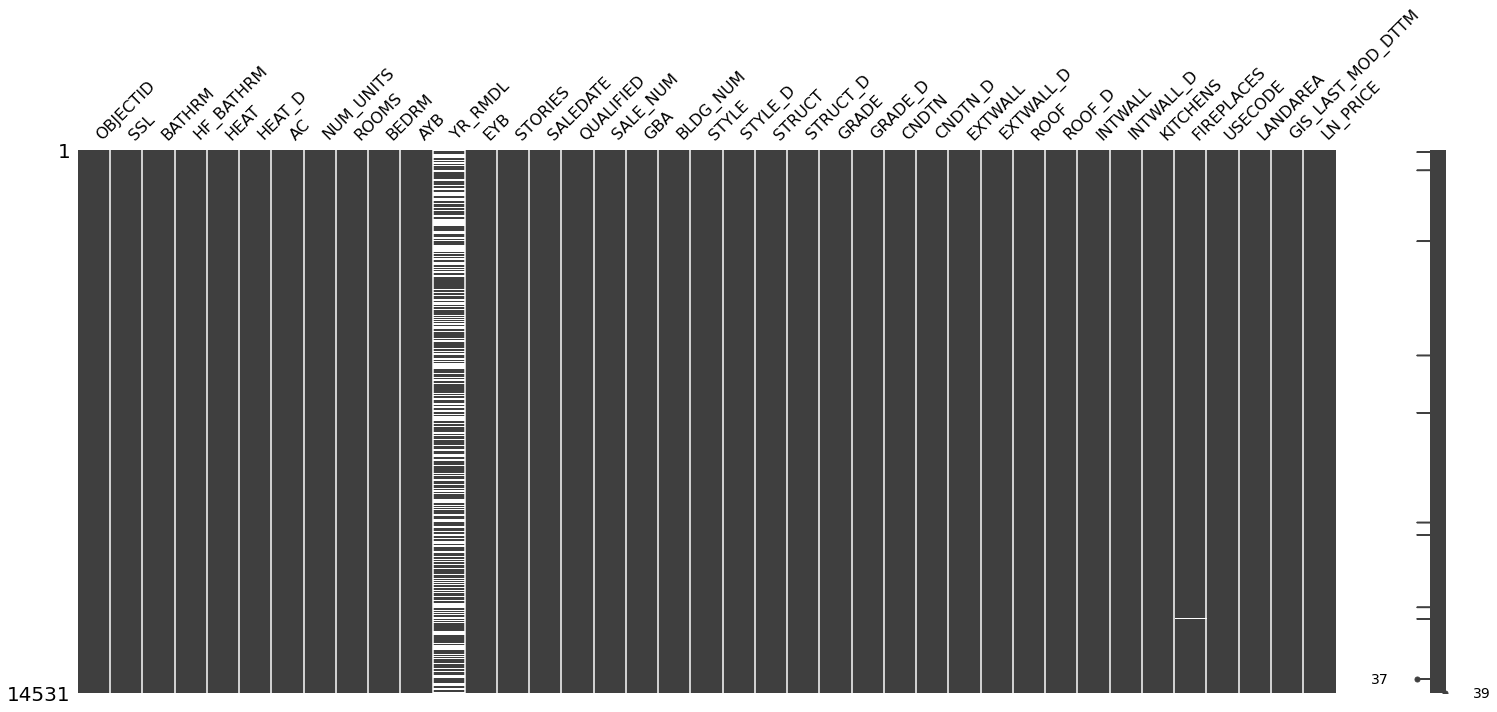

In [4]:
# Look at where missingness occurs in the test data set
miss.matrix(test)

Note: The reason missingness occurs in the YR_RMDL column is simply because some houses haven't been remodeled.

In [5]:
# Reorganize/drop observations

# Only consider houses that have been sold in each data set
train = train[train.LN_PRICE > 0]
test = test[test.LN_PRICE > 0]

# Drop all observations where the outcome is missing in each data set
train = train[~train.LN_PRICE.isna()]
test = test[~test.LN_PRICE.isna()]

# Drop missing values
train = train.dropna()
test = test.dropna()

In [6]:
# Look at shape of train data set (to verify dropped observations)
train.shape

(24996, 39)

In [7]:
# Set outcome and predictor variables in each data set

# OUTCOME: log selling price
train_y = train['LN_PRICE']
test_y = test['LN_PRICE']

# PREDICTORS: number of bathrooms, number of bedrooms, land size
train_x = train[['BATHRM', 'BEDRM', 'LANDAREA']] 
test_x = test[['BATHRM', 'BEDRM', 'LANDAREA']] 

# Fix scale of land area variable (some house are on a lot of land, other on barely a plot)
train_x['LANDAREA'] = np.log(train_x['LANDAREA'])
test_x['LANDAREA'] = np.log(test_x['LANDAREA'])

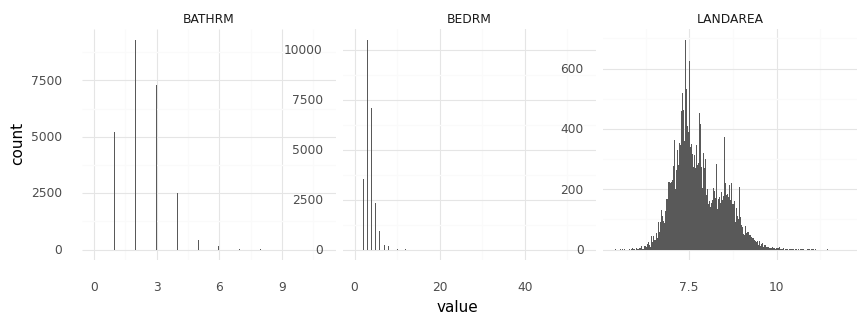

<ggplot: (8765794757039)>

In [8]:
# Look at distributions of train data set
(
    ggplot(train_x.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
) 

After looking at the distributions, we see that scale will be an issue and we will need to pre-process. Also, BATHRM and ROOMS follow a binomial distribution.

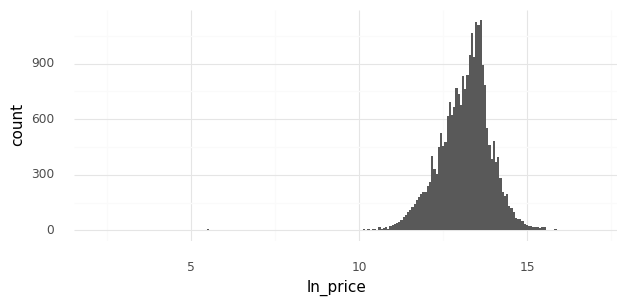

<ggplot: (8765795884794)>

In [9]:
# Visualize the outcome LN_PRICE to see if there's any red flags.
(
    ggplot(pd.DataFrame(dict(ln_price=train_y)),
           aes(x="ln_price")) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (7,3)) 
)

Additionally, we can visualize how the predictors relate to the outcome.

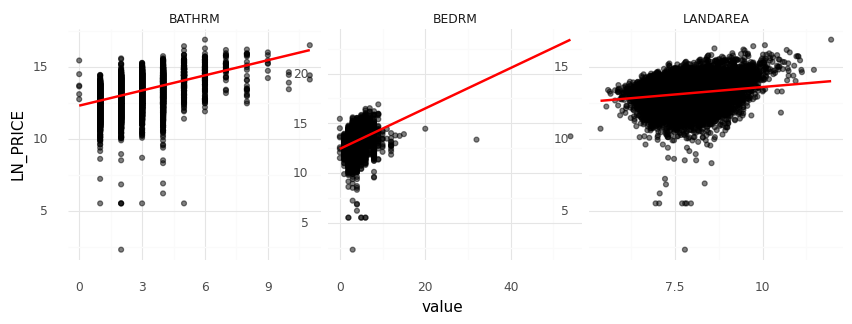

<ggplot: (8765795844247)>

In [10]:
# Create copy of data
D = train_x.copy()
D['LN_PRICE'] = train_y

# Visualize effect of predictors on outcome variable
(
    ggplot(D.melt(id_vars=["LN_PRICE"]),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

### Run Models

In [11]:
# Define K-Fold cross-validation to estimate test errors
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)
# Set performance metric as the mean squared error
use_metrics = ["neg_mean_squared_error"]

In [12]:
# Linear model
lm_scores = cross_validate(LM(),train_x,train_y, cv = fold_generator, scoring = use_metrics)
# KNN model
knn_scores = cross_validate(KNN(),train_x,train_y, cv = fold_generator, scoring = use_metrics)
# Decision tree
dt_scores = cross_validate(DTree(),train_x,train_y, cv = fold_generator, scoring = use_metrics)
# Bagging
bag_scores = cross_validate(Bag(),train_x,train_y, cv = fold_generator, scoring = use_metrics)
# Random forest
rf_scores = cross_validate(RF(),train_x,train_y, cv = fold_generator, scoring = use_metrics)
# Gradient boosting regression
gbr_scores = cross_validate(GBR(),train_x,train_y, cv = fold_generator, scoring = use_metrics)

### Compare Models

In [13]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1,
     gbr = gbr_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.493069
1,lm,0.471447
2,lm,0.480678
3,lm,0.495225
4,lm,0.456219
5,knn,0.533376
6,knn,0.508331
7,knn,0.526568
8,knn,0.544780
9,knn,0.487207


### Plot Models

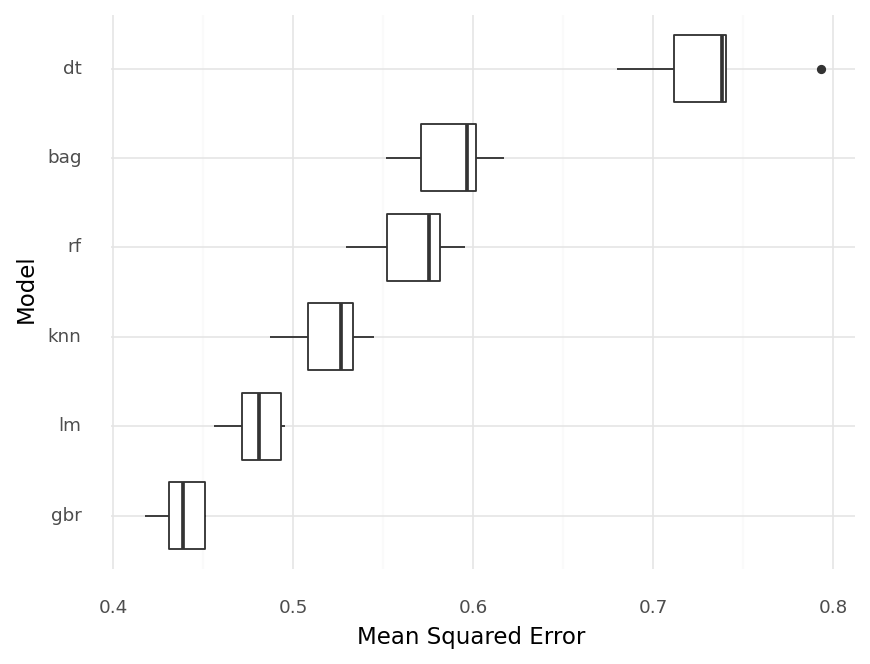

<ggplot: (8765798731837)>

In [14]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

The Gradiant Boosting Regression model appears to perform the best, as it has the lowest mean squared error.

### Tuning Hyper-Parameters

#### Example - manually tune KNN model

In [15]:
set_k = dict()
for k in [1,5,10,50,100,250]:
    score = cross_validate(KNN(n_neighbors=k),
                           train_x,train_y, 
                           cv = fold_generator, 
                           scoring =use_metrics)
    s = score['test_neg_mean_squared_error']
    set_k[k] = s.mean()
 
set_k

{1: -0.8390396055199023,
 5: -0.5200525483104446,
 10: -0.4730493880578134,
 50: -0.4427808995388413,
 100: -0.4401272813731847,
 250: -0.44226888588994956}

In [16]:
# Initialize the model class as KNN
mod = KNN() 
# Report all the available tunning parameters 
mod.get_params() 

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [17]:
# Tune n_neighbors parameter
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}

In [18]:
# Run grid search
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [19]:
# Train model
tune_knn.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [1, 10, 25, 35, 50, 75, 100, 250]},
             scoring='neg_mean_squared_error')

In [20]:
# Find best parameters
tune_knn.best_params_

{'n_neighbors': 100}

In [21]:
# Report best score
tune_knn.best_score_

-0.4401272813731847

In [22]:
# Print results
tune_knn.cv_results_

{'mean_fit_time': array([0.00847654, 0.00890117, 0.00731974, 0.00744085, 0.00723839,
        0.00746107, 0.00737581, 0.00737844]),
 'std_fit_time': array([1.03165195e-03, 1.13031699e-03, 6.80378955e-05, 2.38607494e-04,
        3.75716213e-05, 1.98316798e-04, 1.75751762e-04, 1.63778092e-04]),
 'mean_score_time': array([0.03093247, 0.04249887, 0.0552784 , 0.06623793, 0.08354096,
        0.10874224, 0.1308568 , 0.28718014]),
 'std_score_time': array([0.00279605, 0.0031934 , 0.0041738 , 0.00444453, 0.00486604,
        0.00627454, 0.00722889, 0.01320238]),
 'param_n_neighbors': masked_array(data=[1, 10, 25, 35, 50, 75, 100, 250],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 10},
  {'n_neighbors': 25},
  {'n_neighbors': 35},
  {'n_neighbors': 50},
  {'n_neighbors': 75},
  {'n_neighbors': 100},
  {'n_neighbors': 250}],
 'split0_test_score': array([-0.85822377, 

#### Example - manually tune GBR model

In [31]:
# Initialize the model class as GBR
mod = GBR() 
# Report all the available tunning parameters 
mod.get_params() 

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [39]:
# Tune max_depth parameter
gbr_tune_params = {'max_depth':[1, 3, 5, 7, 9]}

In [40]:
# Run grid search
tune_gbr = GridSearchCV(GBR(),gbr_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [41]:
# Train model
tune_gbr.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'max_depth': [1, 3, 5, 7, 9]},
             scoring='neg_mean_squared_error')

In [42]:
# Find best parameters
tune_gbr.best_params_

{'max_depth': 3}

In [43]:
# Report best score
tune_gbr.best_score_

-0.43802284283108295

In [44]:
# Print results
tune_gbr.cv_results_

{'mean_fit_time': array([0.25271049, 0.60500174, 0.94336128, 1.27222342, 1.59435043]),
 'std_fit_time': array([0.00279573, 0.00314641, 0.0041112 , 0.00538865, 0.01027548]),
 'mean_score_time': array([0.00384722, 0.0063549 , 0.00905418, 0.01200256, 0.01523743]),
 'std_score_time': array([3.78661446e-04, 1.67887152e-04, 2.60804208e-05, 6.22093606e-05,
        1.73958312e-04]),
 'param_max_depth': masked_array(data=[1, 3, 5, 7, 9],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1},
  {'max_depth': 3},
  {'max_depth': 5},
  {'max_depth': 7},
  {'max_depth': 9}],
 'split0_test_score': array([-0.46671486, -0.45089179, -0.45177881, -0.45762148, -0.47245405]),
 'split1_test_score': array([-0.44799994, -0.43110592, -0.43177352, -0.43766002, -0.44574475]),
 'split2_test_score': array([-0.45286004, -0.43863913, -0.43824639, -0.44254926, -0.46145064]),
 'split3_test_score': array([-0.46521504, -0.45185538, -0.45

### Modeling Pipeline
Define modeling pipeline to specify various models and their respective tuning parameters into one grid search. This avoids manually tuning each model like I did for the KNN and GBR models above.

In [47]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), 
                                            ['BATHRM', 'BEDRM', 'LANDAREA'])])


# (3) Create model pipe (note for the model that none is left as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
    
    # Gradient boosting regression 
    {'model': [GBR()],
    'model__max_depth':[3]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'BEDRM',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor()],
                          'model__max_depth': [1, 2, 3, 5]},
                         {'model': [BaggingRegressor()]},


In [48]:
# Mean out-of-sample (CV) error
search.best_score_ 

-0.43801840056201796

In [49]:
# Find parameter setting that gives the best results
search.best_params_

{'model': GradientBoostingRegressor(), 'model__max_depth': 3}

### Test Performance

Now, use the best model from the training data and see how well it performs on the test data set.

In [50]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_x)

In [51]:
# Calculate mean squared error score
m.mean_squared_error(test_y,pred_y)

0.4306679829108491

In [52]:
# Calculate r-squared score
m.r2_score(test_y,pred_y)

0.28933269430667186

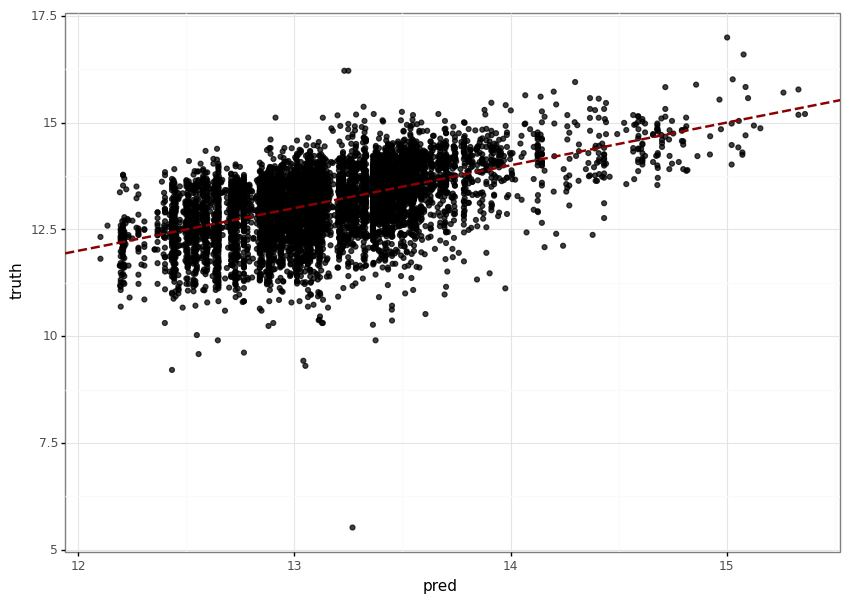

<ggplot: (8765778127869)>

In [53]:
# Visualize the model
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

I first started off by using the original 5 models that we tested in class (Linear, KNN, Decision Tree, Bagging, and Random Forest). Among these models, the best model and parameter was KNN with 30 neighbors. I decided to add an additional model - a Gradient Boosting Regression. This model ended up beating out the original 5 as the best parameter, so this was used to test the model's performance on the test data set. The only parameter I defined was "max_depth" which refers to the maximum depth of the tree. It produced a mean squared error of 0.4309 and a r-squared of 0.2890. Using the same predictors as we did in class, I was able to compare resulting models. In class, the KNN model with 20 neighbors resulted in a mean squared error of 0.5090 and a r-squared value of 0.2467 on the test data. The above Gradient Boosting Regression model performed better, as it reduced the mean squared error and increased the r-squared value from our in-class result. This model predicts the log selling price of a house in DC (based on the number of bathrooms, the number of bedrooms, and the land size) with the best accuracy.